In [ ]:
import keras
import tensorflow as tf
from google.colab import drive
from google.colab import files
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
drive.mount('/content/drive/')

ruta="/content/drive/My Drive/DataSets/Granos_Polen"



Mounted at /content/drive/


In [ ]:
#Filtros para imagenes
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def Neighborhood_Operation(img):
  h, w, c = img.shape
  crop_img = img[0:h, 0:w]

def pixelVal(pix, r1, s1, r2, s2):
    if (0 <= pix and pix <= r1):
        return (s1 / r1)*pix
    elif (r1 < pix and pix <= r2):
        return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1
    else:
        return ((255 - s2)/(255 - r2)) * (pix - r2) + s2

def Contrast_Stretching(img):
  r1 = 66
  s1 = 0
  r2 = 152
  s2 = 255

  pixelVal_vec = np.vectorize(pixelVal)

  contrast_stretched = pixelVal_vec(img, r1, s1, r2, s2)

  cv2_imshow(contrast_stretched)


def Grey_level_slicing(img, T1=100, T2=180):

  h,w = img.shape

  img_thresh_back = np.zeros((h,w), dtype = int)

  for i in range(h):
      for j in range(w):
          if (T1 < img[i,j]).any() and (img[i,j] < T2).any():
              img_thresh_back[i,j]= 255
          else:
              img_thresh_back[i-1,j-1] = img[i-1,j-1]
  return img_thresh_back


def modificar_gamma(img, tipo, gamma=0.5):

  gamma=gamma
  if tipo==1:
    gamma=0.5
  elif tipo==2:
    gamma=1.5
  elif tipo==3:
    gamma=2.
  elif tipo==4:
    gamma=2.5

  gamma_corrected_img = np.array(255*(img / 255) ** gamma, dtype = 'uint8')
  return(gamma_corrected_img)

def masking(img, tipo):
  if tipo==1:
    #Detección de ejes
    kernel = np.array([
            [-1, -1, -1],
            [-1, 8, -1],
            [-1, -1, -1]
          ])
  elif tipo==2:
    #Nitidez de la imagen
    kernel = np.array([
          [0, -1, 0],
          [-1, 5, -1],
          [0, -1, 0]
        ])
  elif tipo==3:
    #"box filtering, suavizado"
    kernel = np.array([
            [1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]
            ]) / 9
  elif tipo==4:
    L = img.max()
    imgNeg = L-img
    cv2_imshow(imgNeg)
    return img
  elif tipo==5:
    kernel = np.array([[-1, -1, -1],
                      [-1, 8, -1],
                      [-1, -1, 0]])
    kernel = 1/3 * kernel
  elif tipo==6:
    kernel = np.array([[-1, -1, -1],
                      [-1, 8, -1],
                      [-1, -1, 0]])
    kernel = 1/3 * kernel
    img=cv2.filter2D(img, -1, kernel)
    img=modificar_gamma(img,2)
    return img
  else:
    return img

  return cv2.filter2D(img, -1, kernel)

def extract_bit_plane(cd):
    #  extracting all bit one by one
    # from 1st to 8th in variable
    # from c1 to c8 respectively
    c1 = np.mod(cd, 2)
    c2 = np.mod(np.floor(cd/2), 2)
    c3 = np.mod(np.floor(cd/4), 2)
    c4 = np.mod(np.floor(cd/8), 2)
    c5 = np.mod(np.floor(cd/16), 2)
    c6 = np.mod(np.floor(cd/32), 2)
    c7 = np.mod(np.floor(cd/64), 2)
    c8 = np.mod(np.floor(cd/128), 2)
    # combining image again to form equivalent to original grayscale image
    cc = 2 * (2 * (2 * c8 + c7) + c6) # reconstructing image  with 3 most significant bit planes
    img=cc
    to_plot = [cd, c1, c2, c3, c4, c5, c6, c7, c8, cc]
    fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for ax, i in zip(axes.flat, to_plot):
        ax.imshow(i, cmap='gray')
    return img


def filtro(img, tratamiento):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


  if tratamiento==0:
    img=img-img.max()
  elif tratamiento==1:
    img=img-img.min()
    img=extract_bit_plane(img)
  elif tratamiento==2:
    img=img-img.min()
    img=masking(img,1)
  elif tratamiento==3:
    img=img-img.min()
    img=masking(img,2)
  elif tratamiento==4:
    img=img-img.min()
    img=masking(img,3)
  elif tratamiento==5:
    img=masking(img,4)
  elif tratamiento==6:
    img=modificar_gamma(img,1)
  elif tratamiento==7:
    img=modificar_gamma(img,2)
  elif tratamiento==8:
    img=modificar_gamma(img,3)
  elif tratamiento==9:
    img=modificar_gamma(img,4)
  elif tratamiento==10:
    img=img-img.min()
    img=Grey_level_slicing(img,10,100)
  elif tratamiento==11:
    img=img-img.min()
    img=255-img
  elif tratamiento==12:
    img=img-img.min()
    img=masking(img,5)
  elif tratamiento==13:
    img=img-img.min()
    img=masking(img,6)

  return img

In [ ]:
#Realizamos o no filtros a las imágenes
import matplotlib.pyplot as plt
import os
import glob

entrenoFiltro=ruta+"/trainFiltro"
testeoFiltro=ruta+"/testFiltro"
valFiltro=ruta+"/valFiltro"

entreno=ruta+"/train"
testeo=ruta+"/test"
val=ruta+"/val"

EnrKunzea=os.listdir(entreno+"/Tipo_A_Kunzea")
TesKunzea=os.listdir(testeo+"/Tipo_A_Kunzea")
ValKunzea=os.listdir(val+"/Tipo_A_Kunzea")

EnrLepto=os.listdir(entreno+"/Tipo_B_Lepto")
TesLepto=os.listdir(testeo+"/Tipo_B_Lepto")
ValLepto=os.listdir(val+"/Tipo_B_Lepto")

files = glob.glob(entrenoFiltro+"/Tipo_A_Kunzea/"+"/*")
for f in files:
    os.remove(f)

files = glob.glob(entrenoFiltro+"/Tipo_B_Lepto/"+"/*")
for f in files:
    os.remove(f)

files = glob.glob(testeoFiltro+"/Tipo_A_Kunzea/"+"/*")
for f in files:
    os.remove(f)

files = glob.glob(testeoFiltro+"/Tipo_B_Lepto/"+"/*")
for f in files:
    os.remove(f)

files = glob.glob(valFiltro+"/Tipo_A_Kunzea/"+"/*")
for f in files:
    os.remove(f)

files = glob.glob(valFiltro+"/Tipo_B_Lepto/"+"/*")
for f in files:
    os.remove(f)


n_tratamiento=3

for i in range(len(EnrKunzea)):
  img=cv2.imread(entreno+"/Tipo_A_Kunzea/"+EnrKunzea[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(entrenoFiltro+"/Tipo_A_Kunzea/"+EnrKunzea[i], img, cmap='gray')

for i in range(len(EnrLepto)):
  img=cv2.imread(entreno+"/Tipo_B_Lepto/"+EnrLepto[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(entrenoFiltro+"/Tipo_B_Lepto/"+EnrLepto[i], img, cmap='gray')

for i in range(len(TesKunzea)):
  img=cv2.imread(testeo+"/Tipo_A_Kunzea/"+TesKunzea[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(testeoFiltro+"/Tipo_A_Kunzea/"+TesKunzea[i], img, cmap='gray')

for i in range(len(TesLepto)):
  img=cv2.imread(testeo+"/Tipo_B_Lepto/"+TesLepto[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(testeoFiltro+"/Tipo_B_Lepto/"+TesLepto[i], img, cmap='gray')

for i in range(len(ValKunzea)):
  img=cv2.imread(val+"/Tipo_A_Kunzea/"+ValKunzea[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(valFiltro+"/Tipo_A_Kunzea/"+ValKunzea[i], img, cmap='gray')

for i in range(len(ValLepto)):
  img=cv2.imread(val+"/Tipo_B_Lepto/"+ValLepto[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(valFiltro+"/Tipo_B_Lepto/"+ValLepto[i], img, cmap='gray')


In [ ]:
#Comprobar que no haya imagenes que se repita en los conjuntos
import os

def intersection (lista):
  nLista=len(lista)
  listaRepetidos=[]
  for i in range(nLista):
    for j in range(nLista):
      if i != j:
        for k in lista[i]:
          if k in lista[j]:
            listaRepetidos.append(k)

  return list(set(listaRepetidos))

entreno=ruta+"/train"
testeo=ruta+"/test"
val=ruta+"/val"

EnrLepto=os.listdir(entreno+"/Tipo_B_Lepto")
TesLepto=os.listdir(testeo+"/Tipo_B_Lepto")
ValLepto=os.listdir(val+"/Tipo_B_Lepto")

print(len(EnrLepto))
print(len(TesLepto))
print(len(ValLepto))

EnrKunzea=os.listdir(entreno+"/Tipo_A_Kunzea")
TesKunzea=os.listdir(testeo+"/Tipo_A_Kunzea")
ValKunzea=os.listdir(val+"/Tipo_A_Kunzea")

print(len(EnrKunzea))
print(len(TesKunzea))
print(len(ValKunzea))

print("Para las carpetas de Kunzea:")
elementos_repetidos = intersection([EnrKunzea,TesKunzea])
print("Elementos repetidos entre la carpeta de entrenamiento y testeo :", elementos_repetidos)
elementos_repetidos = intersection([EnrKunzea,ValKunzea])
print("Elementos repetidos entre la carpeta de entrenamiento y validacion :", elementos_repetidos)
elementos_repetidos =intersection([TesKunzea,ValKunzea])
print("Elementos repetidos entre la carpeta de testeo y validacon :", elementos_repetidos)


print("Para las carpetas de Lepto:")
elementos_repetidos = intersection([EnrLepto,TesLepto])
print("Elementos repetidos entre la carpeta de entrenamiento y testeo :", elementos_repetidos)
elementos_repetidos = intersection([EnrLepto,ValLepto])
print("Elementos repetidos entre la carpeta de entrenamiento y validacion :", elementos_repetidos)
elementos_repetidos = intersection([TesLepto,ValLepto])
print("Elementos repetidos entre la carpeta de testeo y validacon :", elementos_repetidos)

print("Cruze entre carpetas:")
elementos_repetidos = intersection([EnrLepto,EnrKunzea,ValKunzea,TesKunzea])
print("Elementos repetidos entre carpetas EnrLepto :", elementos_repetidos)
elementos_repetidos = intersection([TesLepto,EnrKunzea,ValKunzea,TesKunzea])
print("Elementos repetidos entre carpetas TesLepto :", elementos_repetidos)
elementos_repetidos = intersection([ValLepto,EnrKunzea,ValKunzea,TesKunzea])
print("Elementos repetidos entre carpetas ValLepto :", elementos_repetidos)



960
120
120
960
120
120
Para las carpetas de Kunzea:
Elementos repetidos entre la carpeta de entrenamiento y testeo : []
Elementos repetidos entre la carpeta de entrenamiento y validacion : []
Elementos repetidos entre la carpeta de testeo y validacon : ['Kunzea_855.png', 'Kunzea_844.png']
Para las carpetas de Lepto:
Elementos repetidos entre la carpeta de entrenamiento y testeo : []
Elementos repetidos entre la carpeta de entrenamiento y validacion : ['Lepto_946.png']
Elementos repetidos entre la carpeta de testeo y validacon : []
Cruze entre carpetas:
Elementos repetidos entre carpetas EnrLepto : ['Kunzea_855.png', 'Kunzea_844.png']
Elementos repetidos entre carpetas TesLepto : ['Kunzea_855.png', 'Kunzea_844.png']
Elementos repetidos entre carpetas ValLepto : ['Kunzea_855.png', 'Kunzea_844.png']


In [ ]:
#!pip install tensorflow
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import VGG19


"""
Imagenet es un estándar de facto para la clasificación de imágenes. Se realiza un concurso anual con millones de imágenes de entrenamiento en 1000 categorías. Los modelos utilizados en los concursos de clasificación de
imagenet se miden entre sí para determinar su rendimiento. Por lo tanto, proporciona una medida "estándar" de qué tan bueno es un modelo para la clasificación de imágenes. Muchos modelos de modelo de aprendizaje de
transferencia de uso frecuente utilizan los pesos de imagenet. Su modelo, si está utilizando el aprendizaje por transferencia, se puede personalizar para su aplicación agregando capas adicionales al modelo. No tiene
que usar el peso de imagenet, pero generalmente es beneficioso ya que ayuda a que el modelo converja en menos épocas. Los uso, pero también configuro todas las capas para que se puedan entrenar, lo que ayuda a adaptar
los pesos del modelo a su aplicación.
"""

modelo_P = tf.keras.models.Sequential()
input_shape = (224, 224, 3)


modelo_P.add(VGG19(include_top=False, pooling='avg', weights='imagenet', input_shape=input_shape))

# Agregar algunas capas densas adicionales
modelo_P.add(keras.layers.Dense(512, activation='relu'))
modelo_P.add(keras.layers.Dropout(0.5))  # Capa de dropout para regularización
modelo_P.add(keras.layers.Dense(256, activation='relu'))
modelo_P.add(keras.layers.Dropout(0.5))  # Capa de dropout para regularización

modelo_P.add(keras.layers.Dense(1, activation='sigmoid'))

#ver el número de capas de este modelo:
modelo_P.layers[0].layers

#este modelo es muy lento, puede tardar horas.

modelo_P.layers[0].trainable=False #no queremos reentrenarlos, ya que usamos imagenet

modelo_P.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,418,625
Trainable params: 394,241
Non

In [ ]:
modelo_P.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


entreno=ruta+"/train"
testeo=ruta+"/test"
val=ruta+"/val"


datagen = ImageDataGenerator(
    rescale=1./255)
datagen.flow


train_it = datagen.flow_from_directory(entreno, target_size=(224, 224), batch_size=64, class_mode='binary')
test_it = datagen.flow_from_directory(testeo, target_size=(224, 224), batch_size=64, class_mode='binary')
validation_it = datagen.flow_from_directory(val, target_size=(224, 224), batch_size=64, class_mode='binary')


Found 1920 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [ ]:
# Entrenar el modelo
ajuste=modelo_P.fit(train_it, validation_data=validation_it, epochs=15)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = modelo_P.evaluate(test_it)
print(f"Loss en conjunto de prueba: {loss:.4f}")
print(f"Precisión en conjunto de prueba: {accuracy:.4f}")

Epoch 1/15
30/30 [==============================] - 315s 11s/step - loss: 0.6714 - accuracy: 0.5818 - val_loss: 0.6128 - val_accuracy: 0.5667
Epoch 2/15
30/30 [==============================] - 10s 323ms/step - loss: 0.5597 - accuracy: 0.7089 - val_loss: 0.4326 - val_accuracy: 0.7958
Epoch 3/15
30/30 [==============================] - 10s 326ms/step - loss: 0.4598 - accuracy: 0.7760 - val_loss: 0.3295 - val_accuracy: 0.8708
Epoch 4/15
30/30 [==============================] - 10s 334ms/step - loss: 0.3762 - accuracy: 0.8276 - val_loss: 0.2367 - val_accuracy: 0.9208
Epoch 5/15
30/30 [==============================] - 12s 390ms/step - loss: 0.3022 - accuracy: 0.8792 - val_loss: 0.1823 - val_accuracy: 0.9417
Epoch 6/15
30/30 [==============================] - 11s 347ms/step - loss: 0.2785 - accuracy: 0.8911 - val_loss: 0.2084 - val_accuracy: 0.9167
Epoch 7/15
30/30 [==============================] - 10s 337ms/step - loss: 0.2606 - accuracy: 0.8974 - val_loss: 0.1809 - val_accuracy: 0.9292


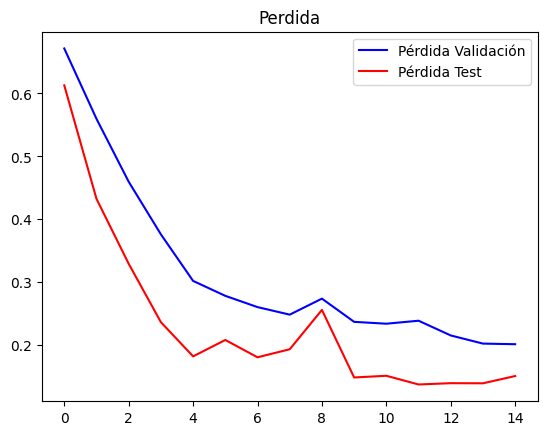

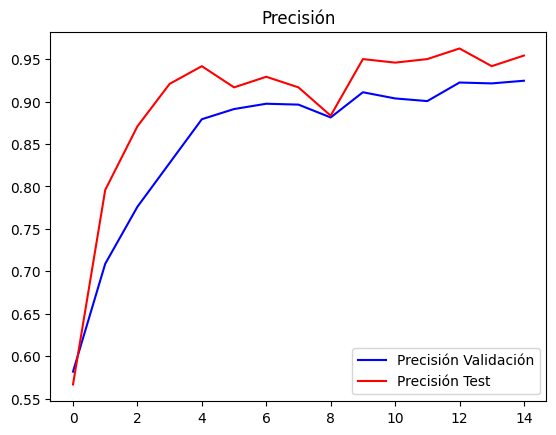

In [ ]:
from matplotlib import pyplot
def seguimiento(ajuste):

  pyplot.figure(0)
  pyplot.title('Perdida')
  pyplot.plot(ajuste.history['loss'], color='blue', label='train')
  pyplot.plot(ajuste.history['val_loss'], color='red', label='test')
  pyplot.legend(['Pérdida Validación','Pérdida Test'])


  pyplot.figure(1)
  pyplot.title('Precisión')
  pyplot.plot(ajuste.history['accuracy'], color='blue', label='train')
  pyplot.plot(ajuste.history['val_accuracy'], color='red', label='test')
  pyplot.legend(['Precisión Validación','Precisión Test'])


seguimiento(ajuste)

8/8 [==============================] - 8s 487ms/step

              precision    recall  f1-score   support

      Kunzea       0.92      0.99      0.96       120
       Lepto       0.99      0.92      0.95       120

    accuracy                           0.95       240
   macro avg       0.96      0.95      0.95       240
weighted avg       0.96      0.95      0.95       240



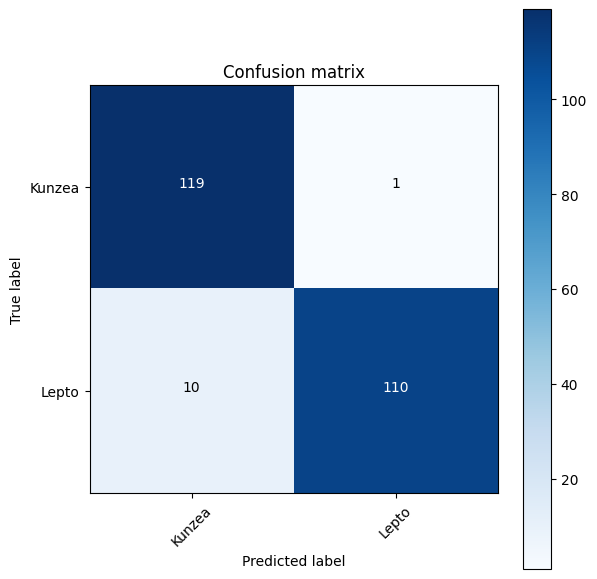

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools


def plot_confusion_matrix(cm, model_name, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.savefig('/content/confusionmatrix-'+ model_name +'.png')
    pyplot.show()

def validateResults(model, model_name):
  validation_images = []  # Lista para almacenar las imágenes
  validation_labels = []  # Lista para almacenar las etiquetas

  i=0
  for batch_images, batch_labels in validation_it:
      validation_images.extend(batch_images)
      batch_label_indices = batch_labels
      validation_labels.extend(batch_label_indices)

      if len(validation_images) >= len(validation_it.filenames):
          break


  validation_images = np.array(validation_images)
  validation_labels = np.array(validation_labels)

  predictions = model.predict(validation_images, batch_size=32)

  y_val=[int(i) for i in validation_labels]

  y_pred= [int(np.round(i)) for i in predictions]


  clases=["Kunzea","Lepto"]
  print("\n"+ classification_report(y_val, y_pred, target_names=clases))
  confusion_mtx = confusion_matrix(y_val, y_pred)
  cm = plot_confusion_matrix(confusion_mtx, model_name, classes = list(clases), normalize=False)

validateResults(modelo_P, 'model1')